In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/tguethle/Documents/spi/Master_Thesis/main_files'))


import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
from astromodels import Powerlaw, PointSource, SpectralComponent
import astropy.time as at
from datetime import datetime
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum, MultinestClusterFit
from RebinningFunctions import spimodfit_binning_SE, log_binning_function_for_x_number_of_bins, no_rebinning #, rebin_data_exp_50
from PointingClusters import PointingClusters, save_clusters, load_clusters
from ModelSources import *
import pickle
from datetime import datetime

Compare the generated counts of pyspi with the output file from Spimodfit. Apperantly the convsky_output file contains these expacted counts

## Spimodfit output

parameters for this spimodfit run 
index = -2
K = 7e-2
piv = 100

In [178]:
# take a look at the response of spimodfit
spimodfit_path = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
response_name = "convolved_sky_images.fits"

with fits.open(spimodfit_path + response_name) as hdul:
    t = Table(hdul[2].data)
    hdul.info()
    header = hdul[2].header
    t2 = Table(hdul[1].data)


counts = t["COUNTS"]

spimodfit_counts = np.array(counts)

t

Filename: /home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/convolved_sky_images.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     29   1R x 6C   [8A, 32A, 1J, 1J, 256A, 3A]   
  2  SPI.-BMOD-DSP    1 BinTableHDU     82   779R x 2C   ['1160E', '1160E']   


COUNTS,STAT_ERR
float32[1160],float32[1160]
3.4685063 .. 16.197575,1.8623927 .. 4.024621
0.66318357 .. 3.1150591,0.81436086 .. 1.764953
0.0 .. 0.0,1.0 .. 1.0
3.5186758 .. 16.475248,1.8758134 .. 4.0589714
3.5177846 .. 16.788109,1.8755758 .. 4.0973296
2.8013792 .. 13.558055,1.6737322 .. 3.6821265
3.546017 .. 16.57452,1.883087 .. 4.071182
0.3743988 .. 1.6950924,0.6118814 .. 1.3019571
0.9874015 .. 4.512073,0.9936808 .. 2.124164


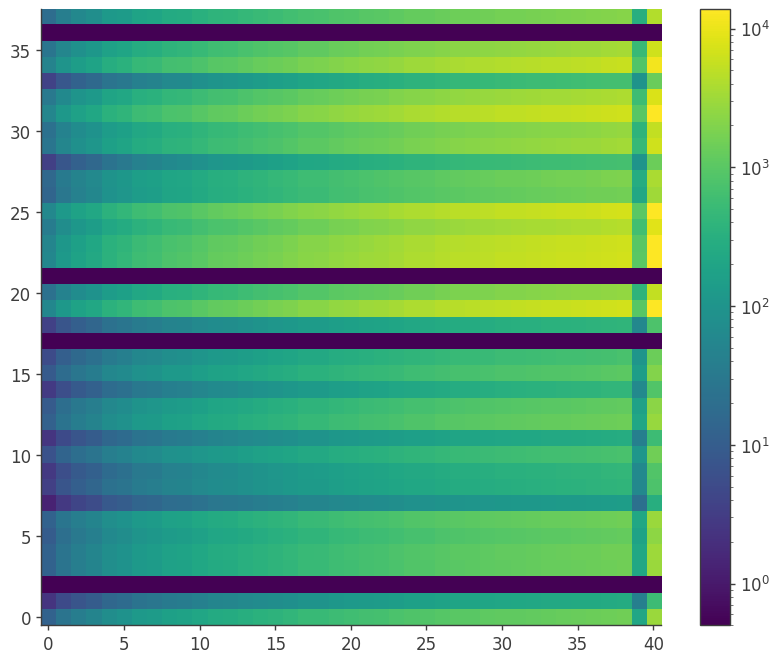

In [153]:
spimodfit_counts[spimodfit_counts < 0.5] = 0.5
plt.figure(figsize=(10, 8))
plt.imshow(spimodfit_counts[0:19*2], origin='lower', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

## Pyspi

In [192]:
# defining the source
K = 7e-2
ra, dec = 10, -40
index_pl = -2
piv = 100
# ra, dec = 155., 75.
# K, piv, index = 3e-3, 40, -1
data_path = '/home/tguethle/Documents/spi/Master_Thesis/main_files/sim_source_real_bkg/bright_100_new/0374'
orig_data_path = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center_small_bins'
# Define  Spectrum
pl = Powerlaw()
pl.piv = piv
pl.K = K
pl.index = index_pl
component1 = SpectralComponent("pl", shape=pl)
source = PointSource("Test", ra=ra, dec=dec, components=[component1])

#emod = np.geomspace(18, 2000, 200)
emod = np.arange(20, 600.5, 0.5)
spec = source(emod)
spec_binned = powerlaw_binned_spectrum(emod, spec)


# Energy Bins
with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    print(f'Number of energy bins: {len(energy_bins)-1}')
# Pointings and Start Times
with fits.open(f"{orig_data_path}/pointing.fits") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


# Time Elapsed
# det=i, pointing_index=j : index = j*85 + i
with fits.open(f"{orig_data_path}/dead_time.fits") as file:
    
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

# Generate Source Counts

assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
version = find_response_version(time_start[0])
rsp_base = ResponseDataRMF.from_version(version)

source_counts = np.zeros((len(pointings)*85, len(energy_bins)-1), dtype=np.uint32)
np_source_counts = np.zeros((len(pointings)*19, len(energy_bins)-1), dtype=np.uint32)

for p_i, pointing in enumerate(pointings):
    
    time = time_start[p_i]
    dets = get_live_dets(time=time, event_types=["single"])
    
    rmfs = []
    for d in dets:
        rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
        
    sds = np.empty(0)
    for d in range(len(dets)):
        sd = SPIDRM(rmfs[d], ra, dec)
        sds = np.append(sds, sd.matrix.T)
    resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))
    
    count_rates = np.dot(spec_binned, resp_mat)
    
    for d_i, d in enumerate(dets):
        index = p_i * 85 + d
        counts_index = p_i * 19 + d
        source_counts[index,:] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])
        np_source_counts[counts_index,:] = count_rates[d_i,:] * time_elapsed[index]

with fits.open(f"{orig_data_path}/evts_det_spec_orig.fits") as file:
    t = Table.read(file[1])
    
    counts = t
    

total_counts = counts["COUNTS"] + source_counts


Number of energy bins: 1160
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)


In [193]:
bin_widths = energy_bins[1:] - energy_bins[:-1]
bin_widths

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

In [ ]:
det_0_resp = resp_mat[0,:,:]

import matplotlib.pyplot as plt
import matplotlib

plt.imshow(det_0_resp, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()


In [ ]:
det_0_resp = resp_mat[5,:,:]

import matplotlib.pyplot as plt

plt.imshow(det_0_resp, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [61]:
time_elapsed[0]

501.3698411373221

In [196]:

energy_bins

array([ 20. ,  20.5,  21. , ..., 599. , 599.5, 600. ], dtype=float32)

In [199]:
np_source_counts[0,-500:]

array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6

Text(0.5, 1.0, 'DET 0 of first pointing')

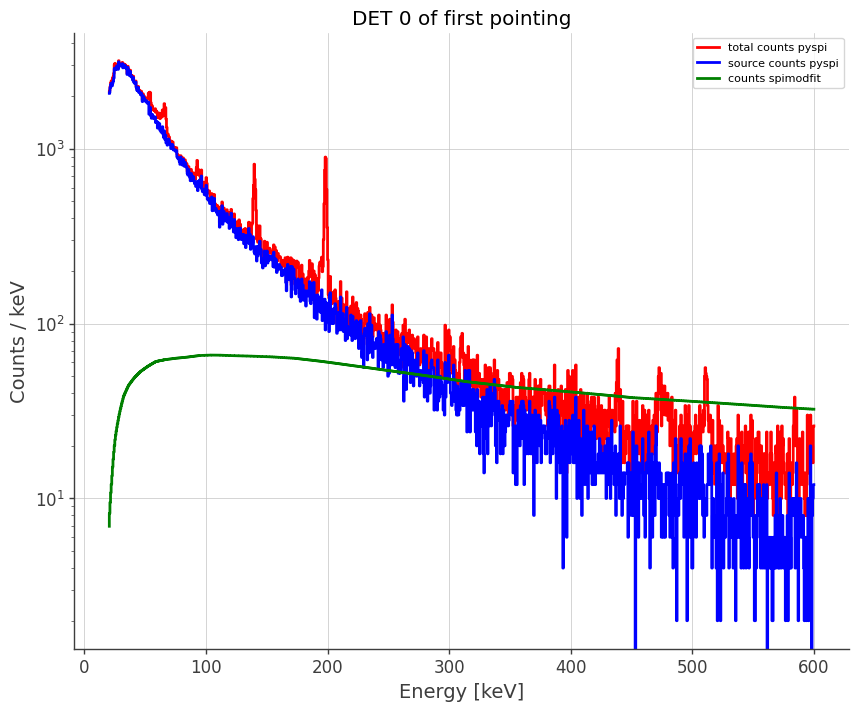

In [202]:
index = 0

plt.figure(figsize=(10, 8))
plt.step(energy_bins[1:], total_counts[index] / bin_widths, label='total counts pyspi', c='r', where='pre')
plt.step(energy_bins[1:], source_counts[index] / bin_widths, label='source counts pyspi', c='b', where='pre')
plt.step(energy_bins[1:], spimodfit_counts[index] / bin_widths, c="g", label='counts spimodfit', where='pre')
#plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Counts / keV')
plt.title("DET 0 of first pointing")

#plt.savefig("counts_comparison_small_bins.png")

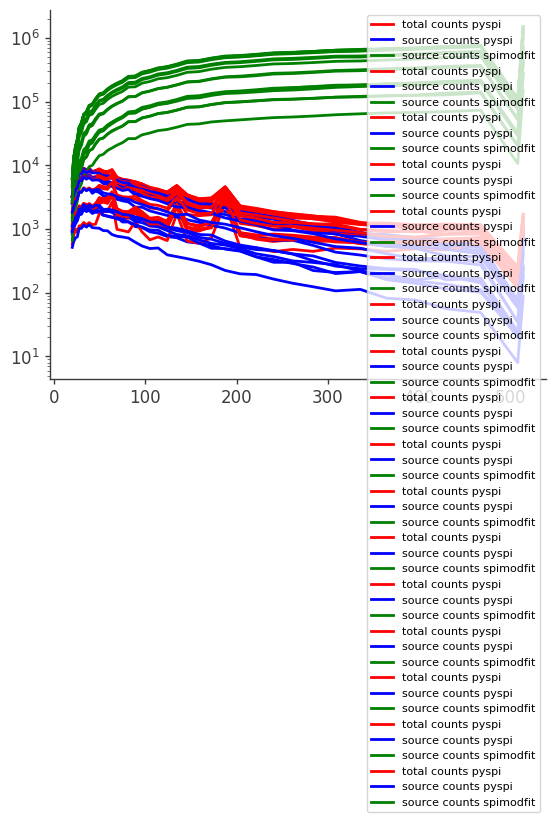

In [115]:
for index in range(0,17):

    plt.plot(energy_bins[:-1], total_counts[index], label='total counts pyspi', c='r')
    plt.plot(energy_bins[:-1], source_counts[index], label='source counts pyspi', c='b')
    plt.plot(energy_bins[:-1], spimodfit_counts[index] * time_elapsed[index], c="g", label='source counts spimodfit')
    #plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
    plt.yscale('log')
    plt.legend()